In [2]:
# import
import pandas as pd
import numpy as np
import glob
import warnings
warnings.filterwarnings('ignore')
#import matplotlib.pyplot as plt
import itertools
import numpy as np
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
# Machine Learning libraries.
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

In [3]:
leftTurn = pd.read_excel("leftturn.xlsx")
data = leftTurn.drop(["File_id","time_of_entering","time_of_exiting","precipitatingEvent","preIncidentManeuver","crashStatus", "crash", "maneuverJudgment", "incomplete_video", "vehicle_movement"], axis = 1)

In [4]:
filledData = data.where(pd.notna(data), data.mean(), axis='columns')
filledData = (filledData - filledData.mean())/filledData.std()
y = leftTurn["crashStatus"]
y[y=="Balanced-Sample Baseline"] = False
y[y != False] = True
y  = np.asarray(y,dtype=np.float64)
print("Number of crashs events: ", sum(y))
print("Class Balance with Crash and no Crash: ", sum(y)/len(y))
# from sklearn.feature_selection import SelectKBest,f_classif
# selector = SelectKBest(f_classif, k=10).fit(filledData,y)
# featurefilledData = selector.transform(filledData)
X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.8)

Number of crashs events:  140.0
Class Balance with Crash and no Crash:  0.509090909091


In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    


def Classifier_performance(clf, target_names, y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, title="confusion matrix"):
    # Fitting the training data
    clf.fit(X_train, y_train)
    
    # Predicting the data
    y_pred = clf.predict(X_test)
    Y_train_pred = clf.predict(X_train)
    
    # Printing the accuracies and confusion matrix
    print("Training Accuracy Score: ", accuracy_score(Y_train_pred , y_train))
    print("validation Accuracy Score:", accuracy_score(y_pred, y_test))
    print("Classification Report: ")
    print(classification_report(y_test, y_pred, target_names=target_names))
    cm = confusion_matrix(y_test, y_pred)
    # Plot normalized confusion matrix
    #plt.figure()
    plot_confusion_matrix(cm, classes=target_names, normalize=False,
                          title=title)

    plt.show()
    plt.close()
    
    # Showing the lower dimension data projection using PCA
    pca = PCA(n_components=2)
    
    # Fitting and transformed the data
    filledData_lower = pca.fit_transform(filledData)
    y = pd.Series(y)
    filledData_lower = pd.DataFrame(filledData_lower)
    filledData_lower['labels'] = y.values
    
    # Creating the figure
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15) # X Axis
    ax.set_ylabel('Principal Component 2', fontsize = 15) # Y Axis
    ax.set_title('2 component PCA', fontsize = 20) # Title
    crash = filledData_lower[filledData_lower["labels"] == 1]
    no_crash = filledData_lower[filledData_lower["labels"] == 0]
    ax.plot(crash[0], crash[1], "*", label=target_names[0])
    ax.plot(no_crash[0], no_crash[1], "o", label=target_names[1])
    plt.legend()
    plt.show()
    plt.close()

# Predicting Crash risk of all the drivers using oridinary least square penality considering crash and near crash as one entry.

Training Accuracy Score:  0.745454545455
validation Accuracy Score: 0.709090909091
Classification Report: 
             precision    recall  f1-score   support

   No_crash       0.72      0.67      0.69        27
      Crash       0.70      0.75      0.72        28

avg / total       0.71      0.71      0.71        55

Confusion matrix, without normalization
[[18  9]
 [ 7 21]]


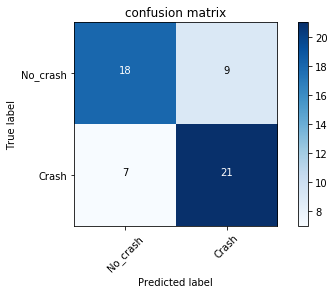

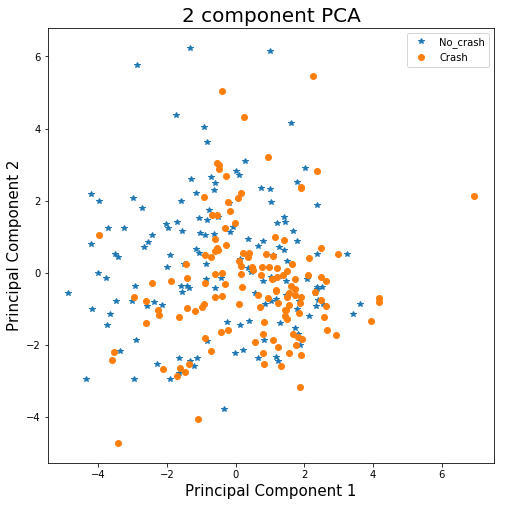

In [6]:
clf = LogisticRegression(max_iter=1000, penalty='l1')
Classifier_performance(clf, ["No_crash", "Crash"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

In [7]:
est = sm.OLS(y, filledData.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     1.768
Date:                Mon, 02 Jul 2018   Prob (F-statistic):             0.0158
Time:                        18:45:00   Log-Likelihood:                -275.00
No. Observations:                 275   AIC:                             600.0
Df Residuals:                     250   BIC:                             690.4
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Time_day                -0.0562 

# Predicting Crash risk for including just crash and baseline condition. (Near crash not considered) using the vehicle profile from both young and old driver.

In [8]:
leftTurn = pd.read_excel("leftturn.xlsx")

# removing the near crash files.
leftTurn = leftTurn[leftTurn["crashStatus"] != 'Near-Crash'] 

data = leftTurn.drop(["File_id","time_of_entering","time_of_exiting","precipitatingEvent",
                      "preIncidentManeuver", "crash", "maneuverJudgment", "incomplete_video", 
                      "vehicle_movement", 'intersection_type'], axis = 1)

# baselines = data[data["crashStatus"]=="Balanced-Sample Baseline"][:60]
# crash = data[data["crashStatus"]=="Crash"]
# data = pd.concat([baselines, crash])

y = data["crashStatus"]
data = data.drop( 'crashStatus', axis=1)
y[y=="Balanced-Sample Baseline"] = False
y[y != False] = True
y  = np.asarray(y,dtype=np.float64)
filledData = data.where(pd.notna(data), data.mean(), axis='columns')
filledData = (filledData - filledData.mean())/filledData.std()
print("Number of crashs events: ", sum(y))
print("Class Balance with Crash and Baseline Condition: ", sum(y)/len(y))
# from sklearn.feature_selection import SelectKBest,f_classif
# selector = SelectKBest(f_classif, k=10).fit(filledData,y)
# featurefilledData = selector.transform(filledData)
X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.7)

Number of crashs events:  35.0
Class Balance with Crash and Baseline Condition:  0.205882352941


Training Accuracy Score:  0.898305084746
validation Accuracy Score: 0.865384615385
Classification Report: 
             precision    recall  f1-score   support

   No_crash       0.85      1.00      0.92        39
      Crash       1.00      0.46      0.63        13

avg / total       0.89      0.87      0.85        52

Confusion matrix, without normalization
[[39  0]
 [ 7  6]]


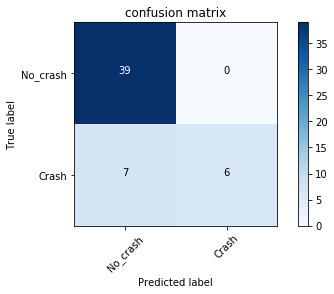

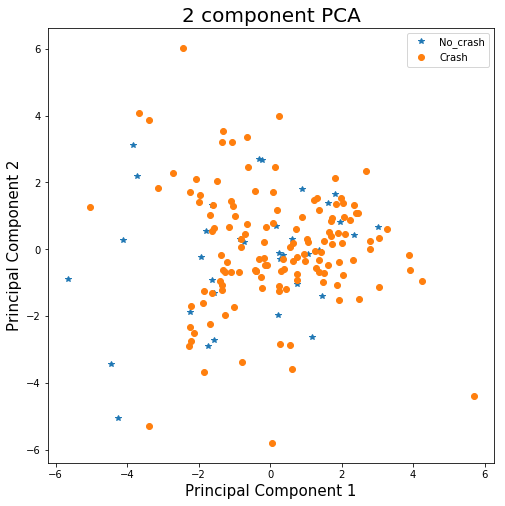

In [9]:
clf = LogisticRegression(max_iter=100, penalty='l1')
Classifier_performance(clf, ["No_crash", "Crash"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

In [11]:
import statsmodels.api as sm
from scipy import stats
est = sm.OLS(y, filledData.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     2.461
Date:                Mon, 02 Jul 2018   Prob (F-statistic):           0.000549
Time:                        18:47:15   Log-Likelihood:                -78.010
No. Observations:                 170   AIC:                             204.0
Df Residuals:                     146   BIC:                             279.3
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Time_day                -0.0797 

# Predicting if the driver is young or old from their driving data all 275 data used

In [12]:
# leftTurn = pd.read_excel("leftturn.xlsx")
data = leftTurn.drop(["File_id","time_of_entering","time_of_exiting","precipitatingEvent",
                      "preIncidentManeuver", "crash", "maneuverJudgment", "incomplete_video", 
                      "vehicle_movement", 'intersection_type', "crashStatus"], axis = 1)

filledData = data.where(pd.notna(data), data.mean(), axis='columns')
filledData = (filledData - filledData.mean())/filledData.std()
y = leftTurn["age"]
y[y >= 65] = True
y[y != True] = False
y  = np.asarray(y,dtype=np.float64)

Number of old drivers:  105.0
Class Balance with old drivers and young driver:  0.617647058824
Training Accuracy Score:  0.754237288136
validation Accuracy Score: 0.596153846154
Classification Report: 
             precision    recall  f1-score   support

      Young       0.47      0.35      0.40        20
        Old       0.65      0.75      0.70        32

avg / total       0.58      0.60      0.58        52

Confusion matrix, without normalization
[[ 7 13]
 [ 8 24]]


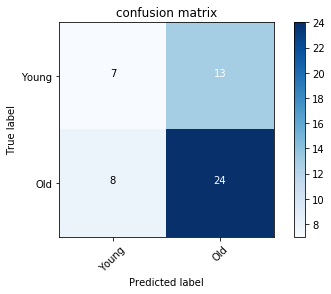

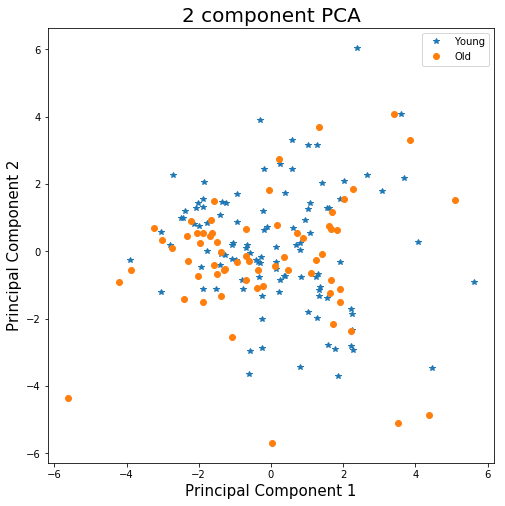

In [13]:
filledData = filledData.drop(["age"], axis =1)
print("Number of old drivers: ", sum(y))
print("Class Balance with old drivers and young driver: ", sum(y)/len(y))
X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.7)
clf = LogisticRegression(max_iter=1000, penalty='l1')
Classifier_performance(clf, ["Young", "Old"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

In [14]:
import statsmodels.api as sm
from scipy import stats
est = sm.OLS(y, filledData.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                 -0.068
Method:                 Least Squares   F-statistic:                    0.5319
Date:                Mon, 02 Jul 2018   Prob (F-statistic):              0.961
Time:                        18:48:40   Log-Likelihood:                -193.47
No. Observations:                 170   AIC:                             432.9
Df Residuals:                     147   BIC:                             505.1
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Time_day                -0.0320 

# Model to predict old driver at risk of crash or not


In [15]:
leftTurn = pd.read_excel("leftturn.xlsx")

old_crash = leftTurn[(leftTurn["age"]>=65) & ((leftTurn["crashStatus"]=="Crash"))]
old_baseline = leftTurn[(leftTurn["age"]>=65) & (leftTurn["crashStatus"]=="Balanced-Sample Baseline")][:30]
leftTurn = pd.concat([old_crash, old_baseline])
data = leftTurn.drop(["File_id","time_of_entering","time_of_exiting","precipitatingEvent",
                      "preIncidentManeuver", "crash", "maneuverJudgment", "incomplete_video", 
                      "vehicle_movement", 'intersection_type'], axis = 1)

y = data["crashStatus"]
data = data.drop( 'crashStatus', axis=1)
y[y=="Balanced-Sample Baseline"] = False
y[y != False] = True
y  = np.asarray(y,dtype=np.float64)
filledData = data.where(pd.notna(data), data.mean(), axis='columns')
filledData = (filledData - filledData.mean())/(filledData.std()+1e-4)
print("Number of crashs events: ", sum(y))
print("Class Balance with Crash and Baseline Condition: ", sum(y)/len(y))
# from sklearn.feature_selection import SelectKBest,f_classif
# selector = SelectKBest(f_classif, k=10).fit(filledData,y)
# featurefilledData = selector.transform(filledData)
X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.7)

Number of crashs events:  23.0
Class Balance with Crash and Baseline Condition:  0.433962264151


Training Accuracy Score:  0.864864864865
validation Accuracy Score: 0.5
Classification Report: 
                        precision    recall  f1-score   support

Old driver not at risk       0.45      0.71      0.56         7
   Old drivers at risk       0.60      0.33      0.43         9

           avg / total       0.54      0.50      0.48        16

Confusion matrix, without normalization
[[5 2]
 [6 3]]


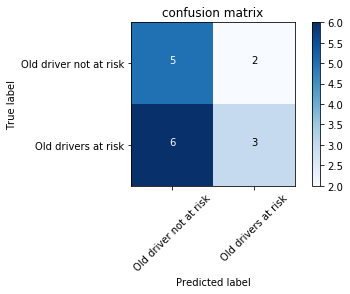

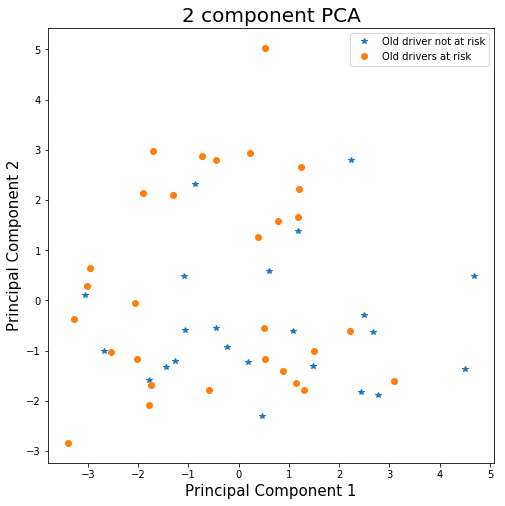

In [16]:
clf = LogisticRegression(max_iter=100, penalty='l1')
Classifier_performance(clf, ["Old driver not at risk", "Old drivers at risk"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

In [17]:
est = sm.OLS(y, filledData.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                 -0.200
Method:                 Least Squares   F-statistic:                    0.5993
Date:                Mon, 02 Jul 2018   Prob (F-statistic):              0.892
Time:                        18:50:06   Log-Likelihood:                -43.691
No. Observations:                  53   AIC:                             131.4
Df Residuals:                      31   BIC:                             174.7
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Time_day                -0.1675 

# Young drivers at the crash risk or not

In [18]:
leftTurn = pd.read_excel("leftturn.xlsx")

young_crash = leftTurn[(leftTurn["age"]<=65) & ((leftTurn["crashStatus"]=="Crash"))]
young_baseline = leftTurn[(leftTurn["age"]<=65) & (leftTurn["crashStatus"]=="Balanced-Sample Baseline")][:20]
leftTurn = pd.concat([young_crash, young_baseline])
data = leftTurn.drop(["File_id","time_of_entering","time_of_exiting","precipitatingEvent",
                      "preIncidentManeuver", "crash", "maneuverJudgment", "incomplete_video", 
                      "vehicle_movement", 'intersection_type'], axis = 1)

y = data["crashStatus"]
data = data.drop( 'crashStatus', axis=1)
y[y=="Balanced-Sample Baseline"] = False
y[y != False] = True
y  = np.asarray(y,dtype=np.float64)
filledData = data.where(pd.notna(data), data.mean(), axis='columns')
filledData = (filledData - filledData.mean())/(filledData.std()+1e-8)
print("Number of crashs events: ", sum(y))
print("Class Balance with Crash and Baseline Condition: ", sum(y)/len(y))
# from sklearn.feature_selection import SelectKBest,f_classif
# selector = SelectKBest(f_classif, k=10).fit(filledData,y)
# featurefilledData = selector.transform(filledData)
X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.7)

Number of crashs events:  10.0
Class Balance with Crash and Baseline Condition:  0.333333333333


Training Accuracy Score:  0.904761904762
validation Accuracy Score: 0.444444444444
Classification Report: 
                        precision    recall  f1-score   support

Old driver not at risk       0.60      0.50      0.55         6
   Old drivers at risk       0.25      0.33      0.29         3

           avg / total       0.48      0.44      0.46         9

Confusion matrix, without normalization
[[3 3]
 [2 1]]


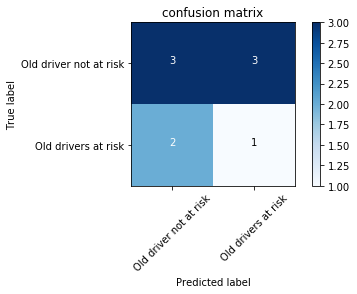

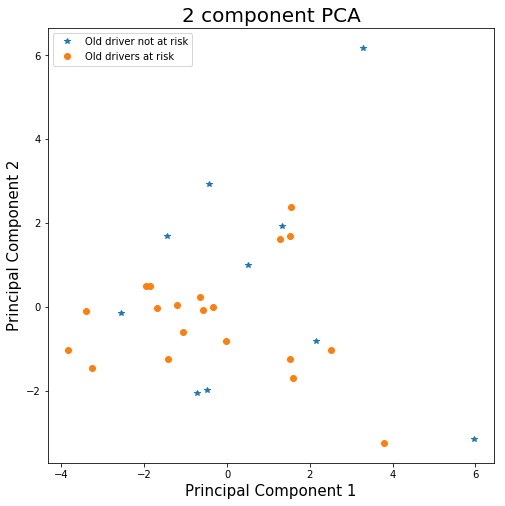

In [19]:
clf = LogisticRegression(max_iter=100, penalty='l1')
Classifier_performance(clf, ["Old driver not at risk", "Old drivers at risk"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )